#**Machine learning for portfolio management and trading**

*Matthieu DONATI ARRANZ and Grégoire CHAUCHOT*

Due by 22 december 2024.


#Introduction<br>

Predicting implied volatility is a critical challenge in risk management, option pricing, and strategic decision-making in financial markets. Among the most traded currency pairs, EUR/USD holds a central role, being influenced by macroeconomic factors, central bank announcements, and market dynamics. This project aims to predict one-month at-the-money forward (1m ATMF) implied volatility on the EUR/USD currency pair, using key variables such as the announcement days of the Federal Reserve (FED) and the European Central Bank (ECB), the EUR-USD interest rate spread, EUR/USD liquidity, and the historical series of implied volatilities.

The implied volatility of options is a forward-looking measure of price fluctuations, reflecting market participants’ expectations about future uncertainty. Numerous studies have demonstrated that implied volatility is not only influenced by recent price and volatility trends but also by exogenous factors such as monetary policy announcements and macroeconomic conditions.

For instance, *Christensen and Hansen (2002)* investigated the impact of central bank announcements on interest rate market volatility and found that announcement days are often associated with significant spikes in implied volatility. Similarly, *Pástor and Veronesi (2012)* showed that major economic announcements directly affect investors’ risk perceptions, altering risk premiums and volatility expectations.

In the foreign exchange market, *Andersen and Bollerslev (1998)* analyzed the relationship between realized volatility and macroeconomic factors in a high-frequency framework. Their work highlights the influence of economic announcements on intraday volatility, a dynamic that could extend to longer-term implied volatility expectations. Additionally, more recent research, such as that by *Gospodinov and Jamali (2015)*, emphasized the importance of interest rate differentials (the spread) as a key determinant of exchange rate variations and volatility.

Liquidity conditions, on the other hand, play a crucial role in the pricing of financial assets. A study by *Mancini, Ranaldo, and Wrampelmeyer (2013)* demonstrated that market liquidity directly influences transaction costs and amplifies or dampens price movements during economic announcements. Finally, the historical series of implied volatilities is often used as a baseline for modeling future expectations due to the persistence of volatility regimes in financial markets.

This project, therefore, builds on a body of research that combines macroeconomic, structural, and technical explanatory variables to improve volatility forecasting. Through machine learning techniques, we aim to capture the complex interactions between these factors to produce accurate predictions of 1m ATMF volatility on the EUR/USD pair. This framework will also evaluate the relative importance of explanatory variables.

### What is 1m ATMF Volatility?

1m ATMF (At-The-Money Forward) volatility represents the implied volatility of a one-month option on the EURUSD currency pair, where the strike price is set at the forward exchange rate of the pair. Implied volatility is a forward-looking measure derived from option prices and reflects market expectations of future price fluctuations over the option's life.

ATMF volatility is a critical input for pricing options, risk management, and understanding the market's sentiment regarding future uncertainties.
<br>


### Formula for the Forward Exchange Rate

The forward exchange rate is key in understanding ATMF options. It represents the rate agreed today for exchanging EURUSD at a specific future date. The forward rate is calculated using a no-arbitrage principle.

$
F_{t,T} = S_t \cdot \frac{\left(1 + r_f \cdot (T-t)\right)}{\left(1 + r_d \cdot (T-t)\right)}
$

Where:  
- $( F_{t,T} )$: Forward exchange rate at time t for maturity T.  
- $(S_t)$: Current spot exchange rate (e.g., EURUSD).  
- $( r_d )$: Domestic interest rate (for EUR in this case).  
- $( r_f )$: Foreign interest rate (for USD in this case).  
- $ (T-t) $: Time to maturity in years (e.g., 1 month = $( \frac{1}{12} ))$.


$( r_d )$ and $( r_f )$ represent the cost of holding EUR (domestic currency) and USD (foreign currency).  

The formula ensures no arbitrage by balancing the cost of holding one currency over the other. If $( r_f > r_d )$, USD is more attractive to hold, making the forward rate higher than the spot rate $( F_{t,T} > S_t )$. Conversely, if $( r_d > r_f)$, the forward rate will be lower than the spot rate.

This forward exchange rate $( F_{t,T} )$ determines the strike price of an ATMF option.


#Our model



In [26]:
!pip install pandas numpy matplotlib beautifulsoup4 requests scikit-learn tqdm ipywidgets scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


In [27]:
#import some libraries we will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests

from sklearn.preprocessing import StandardScaler #To Scale for penalties fairness
from sklearn.linear_model import Lasso, Ridge, ElasticNet #ElasticNet in theory should be enough, but algorithm for Lasso and Ridge are more adapted for their special case (according to sklearn documentation)
from sklearn.metrics import r2_score #r2_score will be the score for Cross-Validation
from tqdm import tqdm


from ipywidgets import widgets
from IPython.display import display

from scipy.stats import norm

We start with a base dataset containing 8 columns : Vol, ECB, Bid-Ask, FED, spread US-EUR, EURUSD=X, EUR Rates and US Rates.
This base dataset includes data from 3 December 2003 to 15 October 2024 on a daily basis for business days.


*   Vol represents the ATMF 1 month implied volatility on EURUSD
*   ECB and FED represent ECB and FED announcement days with a binary representation (1 for an annoucement day 0 for a non-announcement day)
*   spread US-EUR represents the spread between 1m USD risk-free rates (US Rates column) and 1m EUR risk-free rates (EUR Rates column)
*   Bid-Ask represents the Bid-Ask spread on EURUSD (liquidity indicator)
*   EURUSD=X represents the EURUSD exchange rate
<br>
<br>






In [28]:
url_FinalData='https://drive.google.com/uc?id=1G6t30Eb86L18xiE3KzsFZ2lXeq7b7XBi'
df = pd.read_csv(url_FinalData)
df.columns = ['Date'] + list(df.columns[1:])
df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], format='%Y-%m-%d')
df.set_index(df.columns[0], inplace=True)
EURUSD = df["EURUSD=X"]
EUR = df["EUR Rates"]
USD = df["US Rates"]
df.drop(columns=["EUR Rates","US Rates","EURUSD=X"], inplace=True)

In [29]:
def shift_(data,n,lag_=0): #function that will shift a dataframe in time
    ret = pd.concat([data.shift(lag_+i) for i in range(1,n+1)],axis=1)
    ret.columns = [col + '_lag('+str(lag_+i)+')' for i in range(1,n+1) for col in data.columns]
    return ret

The goal will be to predict, 1 month before, the 1m ATMF implied volatility of the EURUSD exchange rate.<br>
y = Vol and X will be lagged values of Vol, Bid-Ask spread, US-EUR risk-free interest rates spread by 22, 44, 66, 132, and 260 business days (which, in this project, represent respectively one, two, three, six months and one year) but also ECB and FED statements the day before, the anouncement day and the day after (as statements dates are known in advance it is not data leakage).<br>
We have chosen lags of 1, 2, 3, 6 months and 1 year in order to capture some seasonality in the series (see the graph below).<br>  



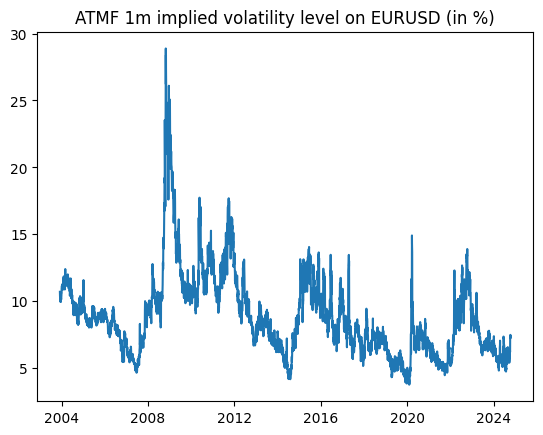

In [ ]:
plt.plot(df.Vol)
plt.title('ATMF 1m implied volatility level on EURUSD (in %)')
plt.show()

**We will try to estimate one month into the future implied volatility as a linear function:**



$
Vol_{t} = c +$ <br>

$.........\beta_{1} \times Vol_{t-22} + \beta_{2} \times Vol_{t-44} + \beta_{3} \times Vol_{t-66} + \beta_{4} \times Vol_{t-132} + \beta_{5} \times Vol_{t-260}+$   

$.........\gamma_{1} \times bds_{t-22} + \gamma_{2} \times bds_{t-44} + \gamma_{3} \times bds_{t-66} + \gamma_{4} \times bds_{t-132} + \gamma_{5} \times bds_{t-260}+$


$.........\delta_{1} \times rfs_{t-22} + \delta_{2} \times rfs_{t-44} + \delta_{3} \times rfs_{t-66} + \delta_{4} \times rfs_{t-132} + \delta_{5} \times rfs_{t-260}+$

$.........\phi_{1} \times ECB_{t-1} + \phi_{2} \times ECB_{t} + \phi_{3} \times ECB_{t+1} + \psi_{1} \times FED_{t-1} + \psi_{2} \times FED_{t} + \psi_{3} \times FED_{t+1} + \varepsilon_{t}
$

*Where:*
- $ Vol_{t-n} $: Lagged values of volatility
- $ bds_{t-n} $: Lagged values of the bid-ask spread.
- $ rfs_{t-n} $: Lagged values of the USD-EUR risk-free rate spread.
- $ ECB $: Dummy variables for ECB statements.
- $ FED $: Dummy variables for FED statements.
- $ \varepsilon_{t} $: Residual error term.
- t represents business day. Temporal distance between Friday and Monday will be considered the same as between Monday and Tuesday


In [30]:
dffp = df.drop(columns=["ECB","FED"])
dffp = pd.concat([shift_(dffp,1,21),shift_(dffp,1,43),shift_(dffp,1,65),shift_(dffp,1,131),shift_(dffp,1,259)],axis=1).dropna()
#Variables Vol, Bid-Ask, Spread US-EUR  are lagged by one, two, three, six and 12 months.
dffp.head(3)

,Vol_lag(22),Bid_Ask_lag(22),spread US-EUR_lag(22),Vol_lag(44),Bid_Ask_lag(44),spread US-EUR_lag(44),Vol_lag(66),Bid_Ask_lag(66),spread US-EUR_lag(66),Vol_lag(132),Bid_Ask_lag(132),spread US-EUR_lag(132),Vol_lag(260),Bid_Ask_lag(260),spread US-EUR_lag(260)
Date,,,,,,,,,,,,,,,
2004-12-01,10.225,0.013596,-0.07675,9.025,0.006402,-0.240,9.80,0.012797,-0.40600,11.00,0.019300,-0.94925,10.70,0.009606,-0.979
2004-12-02,10.275,0.010705,-0.05362,8.925,0.004205,-0.239,9.85,0.007496,-0.40600,11.65,0.008704,-0.93900,10.45,0.016303,-0.978
2004-12-03,9.850,0.007900,-0.04400,8.675,0.012296,-0.240,9.80,0.014690,-0.38875,11.70,0.006295,-0.93575,10.35,0.005303,-0.976


In [31]:
dfs = df[["ECB","FED"]] #statements dates are knonw in advanced, therefore we will be able to use them as explanatory variables even though the statements are in the future
dfs = shift_(dfs,3,-2)
dfs.columns = [c.replace("lag(-","next(") for c in dfs.columns]
dfs.dropna().head(3) #FED and ECB statements the day before, the same day and the next day will be used as explanatory variables

,ECB_next(1),FED_next(1),ECB_lag(0),FED_lag(0),ECB_lag(1),FED_lag(1)
Date,,,,,,
2003-12-04,0.0,0.0,1.0,0.0,0.0,0.0
2003-12-05,0.0,0.0,0.0,0.0,1.0,0.0
2003-12-08,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
dfML = pd.concat([df[["Vol"]],dffp,dfs],axis=1).dropna()
#We concatenated these three dataframes for the "Machine Learining Data Frame". dfML now contains X (explanatory variables) and y (Vol)
#.dropna() dropped the first year since we do not have its lag(1 year) values.
dfML.head(3)

,Vol,Vol_lag(22),Bid_Ask_lag(22),spread US-EUR_lag(22),Vol_lag(44),Bid_Ask_lag(44),spread US-EUR_lag(44),Vol_lag(66),Bid_Ask_lag(66),spread US-EUR_lag(66),...,spread US-EUR_lag(132),Vol_lag(260),Bid_Ask_lag(260),spread US-EUR_lag(260),ECB_next(1),FED_next(1),ECB_lag(0),FED_lag(0),ECB_lag(1),FED_lag(1)
Date,,,,,,,,,,,,,,,,,,,,,
2004-12-01,9.375,10.225,0.013596,-0.07675,9.025,0.006402,-0.240,9.80,0.012797,-0.40600,...,-0.94925,10.70,0.009606,-0.979,1.0,0.0,0.0,0.0,0.0,0.0
2004-12-02,9.075,10.275,0.010705,-0.05362,8.925,0.004205,-0.239,9.85,0.007496,-0.40600,...,-0.93900,10.45,0.016303,-0.978,0.0,0.0,1.0,0.0,0.0,0.0
2004-12-03,9.075,9.850,0.007900,-0.04400,8.675,0.012296,-0.240,9.80,0.014690,-0.38875,...,-0.93575,10.35,0.005303,-0.976,0.0,0.0,0.0,0.0,1.0,0.0


**Temporal Cross-Validation**  
When working with temporal data, standard cross-validation methods, such as 10-fold cross-validation, can lead to issues. In temporal cross-validation, it is inappropriate to use future data to predict past data. Predictions must rely solely on the data available up to that moment in time.  

As a result, the initial portion of the dataset is not used for evaluation. This is because no prior data exists to train a predictive model for that period, while subsequent data is in the future and unavailable for training.  

In our case, where the goal is to predict volatility 22 days in advance, a gap of 22 days must be introduced between the training and test datasets. Reducing this gap (e.g., to 15 days) would create a problem: the volatility at \(22 - 15 = +7\) days would not yet be available, leading to data leakage.  

The procedure is as follows:  
- For each day, starting from the "10th quantile day" up to the last day:  
  1. Train the predictive model using data from "day 0" to "day - 22".  
  2. Test the model exclusively on the given day.  

This procedure ensures that the predictive model's training data would be available at the moment the prediction is made.

In [33]:
frac_initial = 0.1 #We start the temporal Cross Validation from the 10th temporal quantile.
n_initial = int(len(dfML) * frac_initial)  # Start predictions at the 10th quantile (of time)
n = len(dfML) #size of Machine Learning DataFrame

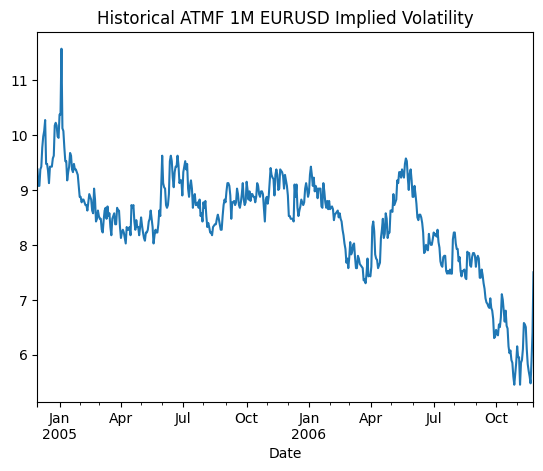

In [34]:
dfML.iloc[:n_initial].Vol.plot()
plt.title("Historical ATMF 1M EURUSD Implied Volatility")
plt.show()

You can, if you want, uncomment the temporal grid-search cross validation but the process is a bit long. <br>

Several models are tested:

## Ridge and Lasso Regression

### Ridge Regression
For a Ridge regression, the betas $\langle \beta_1, ..., \beta_p \rangle $ are chosen to minimize:  
$$
\frac{1}{2} \sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \alpha \sum_{j=1}^p \beta_j^2.
$$  
The Ridge regression generally provides more stable and accurate estimates than a standard linear regression.

### Lasso Regression
For the Lasso regression, the betas $\langle \beta_1, ..., \beta_p \rangle $ are chosen to minimize:  
$$
\frac{1}{2} \sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \alpha \sum_{j=1}^p |\beta_j|.
$$  
The Lasso tends to promote sparse and stable models that can be more easily interpretable.


## Elastic-Net Regression

Finally, for the Elastic Net, the betas $\langle \beta_1, ..., \beta_p \rangle $ are chosen to minimize:  
$$
\frac{1}{2} \sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \alpha \sum_{j=1}^p \left[ (1-\ell) \beta_j^2 + \ell |\beta_j| \right].
$$  
Here,  $\alpha$  controls the overall penalty strength, while $\ell$ determines the balance between the Ridge $\beta_j^2$ and Lasso $|\beta_j|$ penalties.

The Lasso penalty is not very good at selecting individual predictors when they are strong and closely related, while the Ridge penalty tends to make the coefficients of related variables similar. The Elastic Net finds a middle ground by potentially averaging the impact of closely related features while encouraging a simpler model overall.<br>
**Remark**: When $\ell$=1 the penalty corresponds to a Lasso penalty and when $\ell = 0$ the penalty corresponds to a Ridge penalty.

We perform a grid search on Elastic-Net. <br>
Tested values for $\alpha$ are $10^n$ for $n$ from -5 to 1. <br>
Tested values for $\ell$ are 0 (Ridge), 0.1, 0.25, 0.75, 0.9, 1 (Lasso).


In [35]:
dropdown = widgets.Dropdown(
    options=['Download Predictions previoulsy computed', 'Redo Predictions (will generate same results)'],
    value='Download Predictions previoulsy computed',
    description='Choix :',
)

dropdown

Dropdown(description='Choix :', options=('Download Predictions previoulsy computed', 'Redo Predictions (will g…

In [36]:
dropdown.value #check you have enterred the right choice

'Download Predictions previoulsy computed'

In [37]:
# Grille de recherche pour ElasticNet
param_grid = {
    "alpha": [0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    "l1_ratio": [0.1, 0.25,0.5, 0.75, 0.9],
    "model":[["Lasso",Lasso],["Ridge",Ridge]]
}
X = dfML.drop(columns="Vol")
y = dfML.Vol


if dropdown.value == 'Download Predictions previoulsy computed':
  df_pred = pd.read_csv('https://drive.google.com/uc?id=1qy1n465BJzp5vi3z9VSaXkkD-wdqLYTT')
  df_pred.Date = pd.to_datetime(df_pred['Date'], format='%Y-%m-%d')
  df_pred.set_index('Date',inplace=True) #pred previoulsy trained saved in a dataset on drive

else:
  pred = {f'{a},{l}':[] for a in param_grid["alpha"] for l in param_grid["l1_ratio"]}
  pred2 = {f'{a},{m[0]}':[] for a in param_grid["alpha"] for m in param_grid["model"]}
  j = n
  for day in tqdm(range(n_initial, n), desc="Temporal Cross Validation"):

      X_train = X.iloc[:day-21]    #The training has to be lagged by 22 days otherwise the Y value Vol would not have been available when the predictions were made
      y_train = y.iloc[:day-21]    #Vol value. The pred was made 22 days ago so we only had Vol Value up to 22 days ago 22 days ago.


      scaler = StandardScaler()
      X_train_scaled = scaler.fit_transform(X_train)


      X_test = X.iloc[day:day+1]  #We can go up to todays dataframe value for the testset because the values are lagged by 22 days (except for ECB and FED but dates are known in advance so that is okay)


      X_test_scaled = scaler.transform(X_test)



      # Grid Search manuel sur les hyperparamètres
      for alpha in param_grid["alpha"]:
          for l1_ratio in param_grid["l1_ratio"]:
              # Initialisation du modèle ElasticNet
              model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=10, max_iter=1000000)
              model.fit(X_train_scaled, y_train)
              # Prédictions sur le jour suivant (ensemble de test)
              y_test_pred = model.predict(X_test_scaled)[0] #pred made 22 days ago for today implied volatility ATMF value for the given model

              pred[f'{alpha},{l1_ratio}'].append(y_test_pred)
          for m in param_grid["model"]:
              model = m[1](alpha=alpha, random_state=10, max_iter=1000000)
              model.fit(X_train_scaled, y_train)
              y_test_pred = model.predict(X_test_scaled)[0]
              pred2[f'{alpha},{m[0]}'].append(y_test_pred)


  df_pred = pd.concat([pd.DataFrame({k:v for k,v in pred.items()}) , pd.DataFrame({k:v for k,v in pred2.items()})],axis=1)
  df_pred.index = dfML.index[n_initial:n]

In [38]:
for alpha in param_grid["alpha"]:
  for l1_ratio in param_grid["l1_ratio"]:
    print( alpha,l1_ratio,r2_score(dfML.Vol.iloc[n_initial+22:n],df_pred[f'{alpha},{l1_ratio}'].shift(22).dropna()) )
  for m in param_grid["model"]:
    print( alpha,m[0],r2_score(dfML.Vol.iloc[n_initial+22:n],df_pred[f'{alpha},{m[0]}'].shift(22).dropna()) )

1e-05 0.1 0.528873091622786
1e-05 0.25 0.5288724055088911
1e-05 0.5 0.528871202804315
1e-05 0.75 0.5288696186520081
1e-05 0.9 0.5288686207918574
1e-05 Lasso 0.5288680276919906
1e-05 Ridge 0.5288320509851687
0.0001 0.1 0.5292396819088597
0.0001 0.25 0.5292328822667947
0.0001 0.5 0.5292211564855189
0.0001 0.75 0.5292092016392647
0.0001 0.9 0.5292017822888923
0.0001 Lasso 0.5291962591491263
0.0001 Ridge 0.528832389297789
0.001 0.1 0.5326701697837398
0.001 0.25 0.5326599331359803
0.001 0.5 0.5326311825253182
0.001 0.75 0.532596308141449
0.001 0.9 0.5325704451944373
0.001 Lasso 0.5325513895487672
0.001 Ridge 0.5288357720153773
0.01 0.1 0.5538145301422318
0.01 0.25 0.5552534876433151
0.01 0.5 0.5573281270187338
0.01 0.75 0.5591152690983096
0.01 0.9 0.559911493674166
0.01 Lasso 0.560313146036765
0.01 Ridge 0.5288695584580542
0.1 0.1 0.5919541176966925
0.1 0.25 0.597815269052969
0.1 0.5 0.6047072098802568
0.1 0.75 0.6069914804659382
0.1 0.9 0.6041517566773658
0.1 Lasso 0.6026958205973719
0.1 R

Elastic Net with parameters $\alpha = 0.1$ and $\ell = 0.75$ has the best prediction with a $R^2 = 0.607$.<br>
When trained on the entire dataset here is the formula:

In [39]:
model = ElasticNet(alpha=0.1, l1_ratio=0.75, random_state=10, max_iter=1000000)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
model.fit(X_train_scaled, y)

scaled_coefficients = model.coef_
unscaled_coefficients = scaled_coefficients / scaler.scale_
unscaled_intercept = model.intercept_ - (scaled_coefficients @ (scaler.mean_ / scaler.scale_))

In [40]:
('Vol = '+f'{unscaled_intercept:.2e} + '+' + '.join([f'{unscaled_coefficients[i]:.2e}x{X.columns[i]}' for i in range(len(unscaled_coefficients)) if abs(unscaled_coefficients[i])>0])).replace('+ -','- ').replace('Bid_Ask','bds').replace('spread US-EUR','rfs')

'Vol = 2.50e+00 + 6.49e-01xVol_lag(22) + 2.93e+00xbds_lag(22) + 9.80e-02xVol_lag(44) - 2.00e-01xrfs_lag(44) - 6.10e-02xrfs_lag(66) - 1.65e-01xrfs_lag(132)'

**With Elastic-Net ($\alpha=0.1$, $\ell=0.75$), we ended with the following equation for the volatility forecast :**

$
\hat{Vol_t} = 2.50 + 0.649 \times Vol_{t-22} + 2.93 \times bds_{t-22} + 9.80 \cdot 10^{-2} \times Vol_{t-44} - 0.20 \times rfs_{t-44} - 6.10 \cdot 10^{-2}  \times \cdot rfs_{t-66} - 0.165 \times 10^{-1} \cdot rfs_{t-132} $<br>


Where:

$Vol_{t-n}$ : n days lagged values of volatility <br>
$bds_{t-n}$ : n days lagged values of the bid-ask spread.<br>
$rfs_{t-n}$: n days lagged values of the USD-EUR risk-free interest rate spread.
<br>
<br>
<br>

# Some formulas before presenting our trading strategy<br>
<br>

Let's say we buy an European straddle at time t+22 expiring at time t+44.
To buy this straddle in dollar, I borrow the amount of money to finance this product. Therefore, I pay nothing at time t+22 and at time t+44, I will received the straddle gain and will have to repay the loan notional used to buy the straddle at time t+22 + interests.
<br>
Therefore, the PnL at time t+44 is: <br>

$PnL_{t+44} = |S_{t+44} - S_{t+22}.\frac{(12+r_{USD})}{(12+r_{EUR})}| - PS_{ATMF}(\sigma)\times(1+\frac{r_{USD}}{12})$ <br>

*where r is the risk-free interest rate of the currency between time t+22 and t+44.*

<br>

An European straddle is an European call + an European put. <br>
At The Money Forward (ATMF), a Call and a Put have the same price.   
Indeed: <br>
 $C(S,K,T) - P(S,K,T) = S_0 - K\cdot e^{-(rT)}$ <br>
 ATMF means $K = S_0\cdot e^{rT}$ <br>
 Therefore : $C(S,S_0\cdot e^{rT},T) = P(S,S_0\cdot e^{rT},T)$
<br>
<br>

ATMF, the price of a Call (using Black-Scholes formula) is the following:
$S_0\cdot(2\cdot N(\frac{\sigma}{2}\sqrt{T}) - 1)$

Indeed, let's remind the Black-Scholes formula to price a call:

A Call cost: $S_0\cdot N(d1) - K\cdot e^{-rT}\cdot N(d2)$ <br>
with $d1 = \frac{\ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})\cdot T}{\sqrt{T}\cdot sigma}$ <br>


Since $K = S_0\cdot e^{rT} => ln(\frac{S_0}{K}) = ln(\frac{S_0}{S_0\cdot e^{rT}}) = ln(\frac{1}{e^{rT}}) = ln({e^{-rT}}) = - rT$

<br>

So, $d1 = \frac{- rT + rT + \frac{\sigma^2}{2}T }{\sqrt{T}\cdot \sigma} = \frac{\frac{\sigma^2}{2}T}{\sqrt{T}\cdot \sigma} = \frac{\sigma}{2}\sqrt{T} $ <br>

and, $d2 = d1 - \sigma\cdot \sqrt{T} = - \frac{\sigma}{2}\sqrt{T} = -d1$ <br>


Since $d1 = -d2 <=> N(d1) = 1 - N(d2)$ <br><br>
Therefore: <br>
$S_0\cdot N(d1) - K\cdot e^{-rT}N(d2) = S_0\cdot N(d1) - S_0\cdot N(d2) = S_0\cdot ( N(d1) - N(d2) ) = S_0\cdot(N(d1) - (1-N(d1)) )$
$= S_0\cdot (2N(d1) - 1) $ <br>
$= S_0\cdot(2\cdot N(\frac{\sigma}{2}\sqrt{T}) - 1)$

<br>
We end with :<br>
$Straddle = Call + Put =2\cdot Call = 2\cdot S_0\cdot(2\cdot N(\frac{\sigma}{2}\sqrt{T}) - 1)$

So, $PnL_{t+44} = |S_{t+44} - S_{t+22}.\frac{(12+r_{USD})}{(12+r_{EUR})}| - PS_{ATMF}(\sigma)\times(1+\frac{r_{USD}}{12}) = |S_{t+44} - S_{t+22}.\frac{(12+r_{USD})}{(12+r_{EUR})}| - 2\cdot S_{t+22}\cdot(2\cdot N(\frac{\sigma}{2}\sqrt{T}) - 1)\times(1+\frac{r_{USD}}{12})$ <br>
<br>
Since $T =\frac{1}{12}$: <br>
$PnL_{t+44} =|S_{t+44} - S_{t+22}.\frac{(12+r_{USD})}{(12+r_{EUR})}| - 2\cdot S_0\cdot(2\cdot N(\frac{\sigma}{2}\sqrt{\frac{1}{12}}) - 1)\times(1+\frac{r_{USD}}{12}) $





#The trading strategy
Our strategy is: <br>
At time t: <br>
- Predict the explicit volatility between time t+22 and t+44: $\hat{\sigma}_{\text{t+22 to t+44|t}}$ <br>

At time t+22: <br>
- Compare $\hat{\sigma}_{\text{t+22 to t+44|t}}$ to $\sigma_{\text{t+22 to t+44}}$, the $\hat{\sigma}_{\text{t+22 to t+44|t}}$ is chosen from the model that generates a forecast that maximizes the PnL at each strategy set up date.
- If $\hat{\sigma}_{\text{t+22 to t+44|t}}$ > $\sigma_{\text{t+22 to t+44}}$ : compared to our prediction, less volatility over 1m on EURUSD is seen, we see in this a signal of undervaluation: we go long and borrow money at fixed rate.
- If $\hat{\sigma}_{\text{t+22 to t+44|t}}$ < $\sigma_{\text{t+22 to t+44}}$ : compared to our prediction, more volatility over 1m on EURUSD is seen, we see in this a signal of overvaluation: we go short and invest money at fixed rate.


At time t+44: <br>
- Each time I lend (or borrow) my $PnL_{t+44}$ in dollar at the USD risk-free rate between t+44 and t+66 (for 1 month). At time t+44, I am also going to receive (or repay) the money from the $PnL_{t+22}$ that was invested (or borrowed) at the $rfr_{(\text{USD t+22 to t+44)}}$ between t+22 and t+44 but also $PnL_{t}$ that was successively invested between t and t+22 at $rfr_{(\text{USD t to t+22)}}$ and then between t+22 and t+44 at $rfr_{(\text{USD t+22 to t+44)}}$ ...



Therefore, we will have 22 funds in parallel. Each date, we retrieve not only the daily PnL but also the PnL of the business dates sharing the same modulo 22. <br>

When we reach the last 22 observations days, we sum the 22 funds to estimate the total gains.

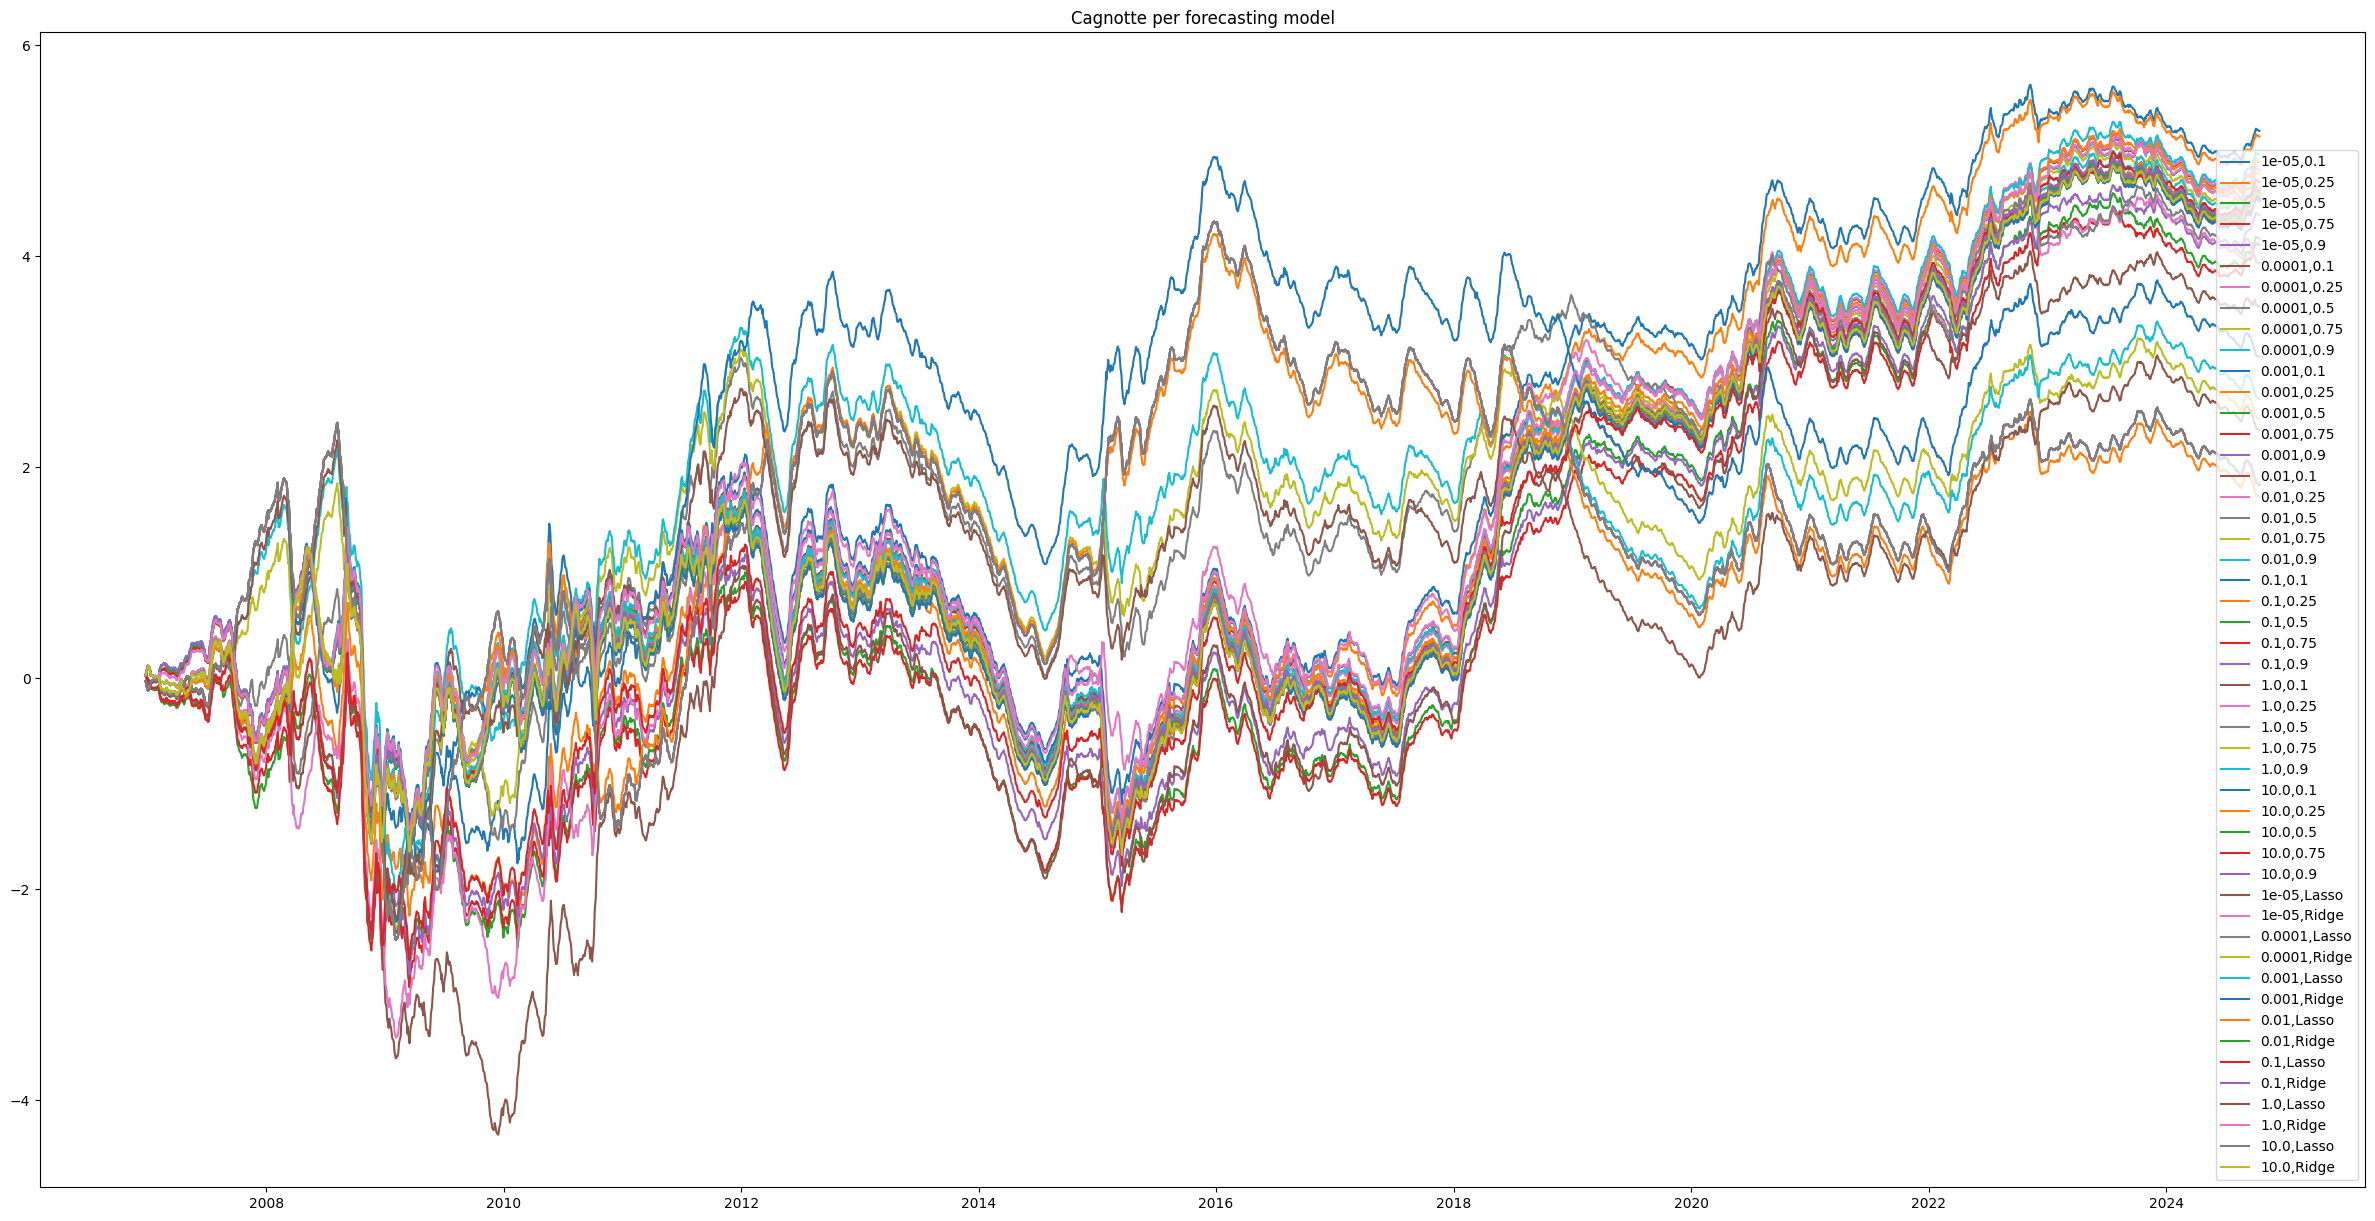

In [41]:
df_predd = df_pred.copy()
for c in df_predd.columns:
  df_predd[c] = 2*(df_predd[c] > dfML.iloc[n_initial:n].Vol)-1 #Short/Long signal

df_predd = df_predd.shift(22).dropna()

#Cummulative USD risk-free rates
INV = pd.concat(
    [(1+USD.loc[df_predd.index].iloc[ [i for i in range(len(df_predd)) if i%22==j ] ].iloc[::-1].shift(1).fillna(0)/1200).cumprod() for j in range(22)]
    ,axis=0).sort_index().to_frame().rename(columns={'US Rates':'Inv'})

#invest or borrow in function of the signal
for c in df_predd.columns:
  df_predd[c] = df_predd[c]*INV.Inv



#straddle payoff
StrPay = abs(EURUSD - EURUSD.shift(22)*(1+USD.shift(22)/1200)/(1+EUR.shift(22)/1200)).dropna() #Gain from a straddle at time t+44 in dollars
#Straddle premium
PrimePay = ((
    2*EURUSD.shift(22)*(2*norm.cdf(0.5*np.sqrt(1/12)*(df.Vol/100).shift(22))-1)
    )*(1+USD.shift(22)/1200)
).dropna()

PnL = StrPay - PrimePay

#invest or borrow the PnL in function of the signal
for c in df_predd.columns:
  df_predd[c] = df_predd[c]*PnL.loc[df_predd.index]

#cummulative PnL
df_predd_sum = df_predd.cumsum()


plt.figure(figsize=(30,15))
for c in df_predd_sum.columns:
  plt.plot(df_predd_sum.index, df_predd_sum[c], label = c)
plt.legend()
plt.title('Cagnotte per forecasting model')
plt.show()

In [ ]:
#We set the best performing model over the period, our strategy, long only and short only strategies
best_hist_strat = df_predd_sum.idxmax(axis=1).shift(1).fillna('1e-05,0.1').values
Strat_PO = pd.DataFrame([df_predd.iloc[i][best_hist_strat[i]] for i in range(len(df_predd))],columns = ['Strat best hist'], index = df_predd_sum.index).cumsum()['Strat best hist']

POB = (INV.Inv*PnL.loc[df_predd.index].cumsum()).iloc[-1]
POS = -POB

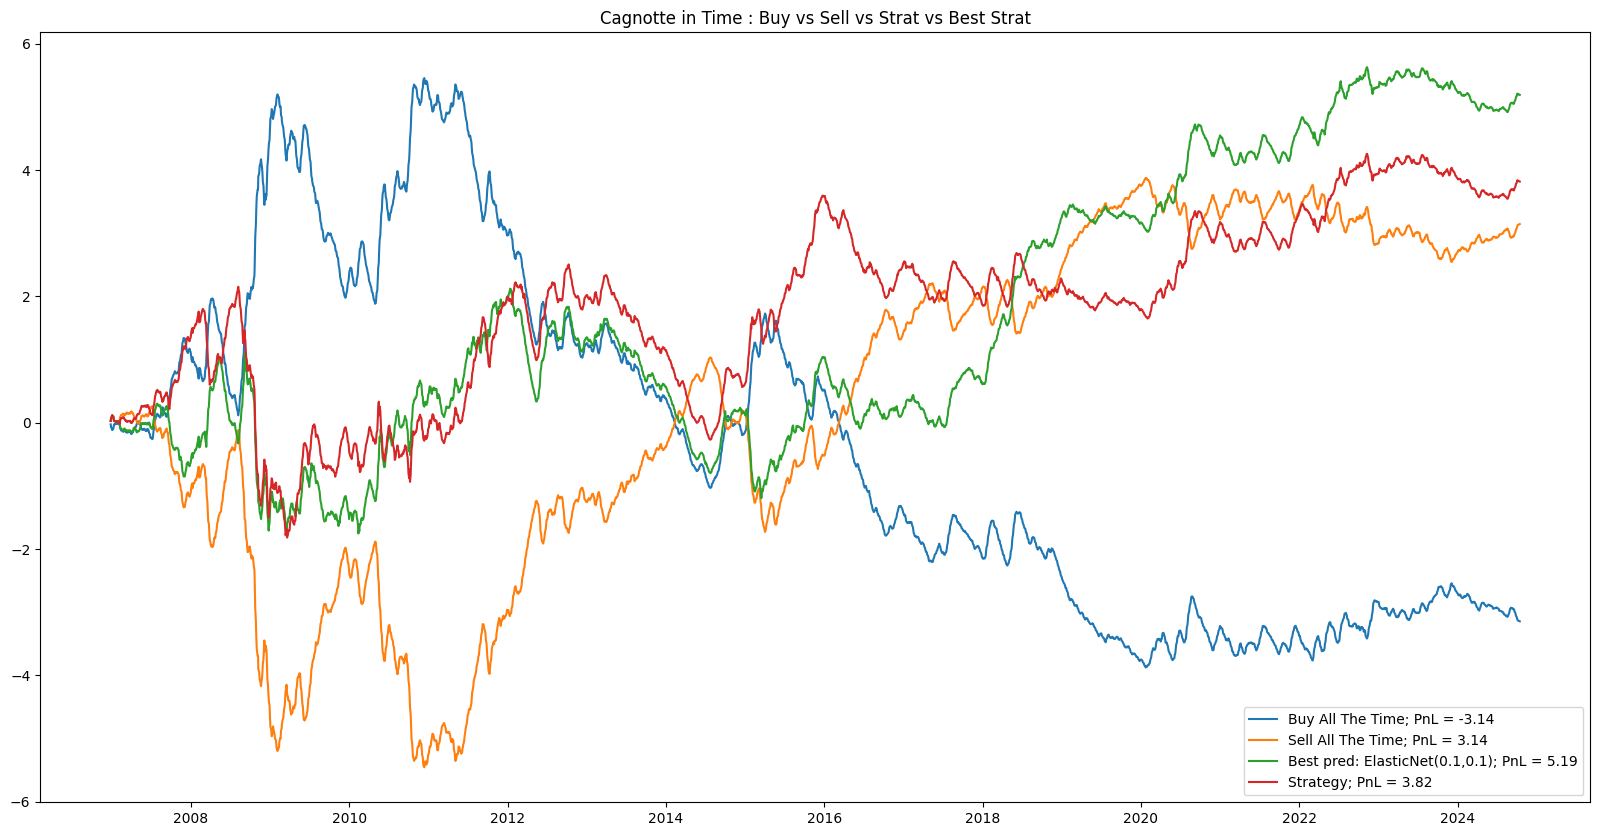

In [42]:
plt.figure(figsize=(20,10))
plt.plot(df_predd.index, INV.Inv*PnL.loc[df_predd.index].cumsum(),label=f'Buy All The Time; PnL = {POB.round(2)}')
plt.plot(df_predd.index, -INV.Inv*PnL.loc[df_predd.index].cumsum(),label=f'Sell All The Time; PnL = {POS.round(2)}')
plt.plot(df_predd.index, df_predd_sum[best_hist_strat[-1]].values,label = f'Best pred: ElasticNet({best_hist_strat[-1]}); PnL = {df_predd_sum.iloc[-1][best_hist_strat[-1]].round(2)}')
plt.plot(df_predd.index, Strat_PO.values, label = f'Strategy; PnL = {Strat_PO.iloc[-1].round(2)}')

plt.legend()
plt.title('Cagnotte in Time : Buy vs Sell vs Strat vs Best Strat')
plt.plot( )
plt.show( )

In conclusion, we can see that our strategy using numerous forecasting model in order to choose the forecast that maximizes the PnL has performed well over the period and created profit. Over the whole period and increasingly over time, this strategy enabled to avoid large variations, reduce volatility and has overperformed long only and short only strategies.<br>
 More generally, we see that using a forecasting models based on ECB and FED anouncements, a liquidity indicator, risk-free rates spread and historical 1m ATMF implied volatility values in order to capture an under/over-valuation signal is profitable and offers some preview about future price variations on EURUSD.

***Sources***<br>

*   Christensen, B. J., & Hansen, C. S. (2002). "New Evidence on the Impact of Macroeconomic Announcements on Interest Rates Volatility."

*   Pástor, L., & Veronesi, P. (2012). "Uncertainty about Government Policy and Stock Prices." Journal of Finance.

*   Andersen, T. G., & Bollerslev, T. (1998). "Answering the Skeptics: Yes, Standard Volatility Models Do Provide Accurate Forecasts." International Economic Review.

*   Gospodinov, N., & Jamali, I. (2015). "Monetary Policy Uncertainty, Interest Rate Volatility, and the Forward Premium Puzzle." Journal of Financial Economics.

*   Mancini, L., Ranaldo, A., & Wrampelmeyer, J. (2013). "Liquidity in the Foreign Exchange Market: Measurement, Commonality, and Risk Premiums." Journal of Finance.


